# Exercise 1: Static portfolio choice problem

Consider a portfolio choice problem where an investor chooses the fraction $\alpha$ to invest in a risky asset in order to maximize expected utility,
$$
\max_{\alpha \in [0, 1]} \mathbb{E}_t\left[u(W_{t+1})\right]
$$
Assume that the investor consumes all of next-period's wealth $W_{t+1}$ which is given by
$$
W_{t+1} = \underbrace{R_{t+1} \alpha W_t}_{\text{Return on risky asset}} 
+ \underbrace{R_f (1-\alpha) W_t}_{\text{Return on risk-free asset}}
$$
where $W_t$ is the initial investable wealth in period $t$, $R_{t+1}$ is the gross return on the risky investment and $R_f$ is the risk-free return on the fraction of the portfolio which is invested a risk-free asset (e.g., a bank deposit).
The utility function $u(\bullet)$ has a constant relative risk aversion (CRRA) form and is given by
$$
u(W) = \begin{cases}
\frac{W^{1-\gamma}}{1-\gamma} & \text{if } \gamma \neq 1 \\
\log(W) & \text{if } \gamma = 1
\end{cases}
$$
where $\gamma$ is a parameter governing the investor's risk aversion.

For simplicity, let the gross risk-free return be $R_f = 1$.
Finally, assume that the risky return can take on two realizations, high and low, with equal probability,
$$
R_{t+1} = \begin{cases}
1 + \mu + \epsilon & \text{with probability } \frac{1}{2} \\
1 + \mu - \epsilon & \text{with probability } \frac{1}{2} \\
\end{cases}
$$
where $\mu > 0$ is the risk premium and $\epsilon > 0$ parametrizes the volatility of risky returns.

In this exercise, you are asked to compute the optimal risky share and investigate how it depends on initial wealth.
Unless stated otherwise, assume that the problem is parametrized with $W=1$, $\gamma = 2$, $\mu = 0.04$, and $\epsilon=0.2$.

1. Compute the expected risky return, the risk premium $\mathbb{E}[R_{t+1}] - R_f$, and the Sharpe ratio for the risky asset.

    *Hint:* The Sharpe ratio is defined as $(\mathbb{E}[R_{t+1}] - R_f)/\sigma_R$ where $\sigma_R$ is the standard deviation of risky returns.

2. Write a Python function that takes as arguments the risky share $\alpha$, the initial wealth $W_t$, and the parameters $\mu$, $\epsilon$ and $\gamma$, 
    and returns the expected utility associated with the given values.
    Your function signature should look like this:

    ```python
    def expected_util(alpha, W, mu, epsilon, gamma):
        """
        Return the expected utility of investing a share alpha into 
        the risky asset for given parameters.

        Parameters
        ----------
        alpha: float or array
            Risky share
        W : float
            Initial wealth
        mu : float 
            Equity premium
        epsilon : float
            Variance of risky returns
        gamma : float
            Relative risk aversion

        Returns
        -------
        float or array
            Expected utility associated with choice alpha.
        """
    ```

    Make sure that your function works correctly for both $\gamma = 1$ and $\gamma \neq 1$. Moreover, the function should allow for the arguments $\alpha$ and $W$ to be passed as both scalar values as well as NumPy arrays!

3. Using the function you wrote, evaluate the expected utility on a grid of risky shares $\alpha$ with 1001 points 
        which are uniformly spaced on the interval $[0, 1]$.

    Plot this expected utility against the risky share. Label both axes and add a legend to your plot.

4. In the previous question, you plotted the expected against _all_ possible risky share choices.
   Using grid search, find the optimal risky share and the associated expected utility.

   Augment the plot you created earlier and add a vertical dashed line to indicate the optimal risky share.

   *Hint:* You can use [`np.argmax()`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) for to locate the utility-maximizing risky share.

   *Hint:* Use [`axvline()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html) to add a vertical line.

5. Now consider a set of 100 initial wealth levels $W_t$ which are uniformly spaced over the interval $[1, 10]$.
    
    - Write a loop that computes the optimal risky share for each of these wealth levels. Use the same values for the remaining parameters as above.
    - Plot the optimal risky share against the grid of initial wealth levels. Set the $y$-axis
    limits to $(0, 1)$ to better visualize the result and explain your findings.

### Solution

#### Part (1)

In [1]:
# Model parameters
W = 1.0             # Initial wealth
gamma = 2.0         # Relative risk aversion
mu = 0.04           # Risk premium
epsilon = 0.2       # Standard deviation of risky return
Rf = 1.0            # Gross risk-free return

In [2]:
import numpy as np

# Probabilities of risky return
probs = np.array([0.5, 0.5]) 

# Risky return realizations
returns = np.array([1 + mu + epsilon, 1 + mu - epsilon])

# Expected risky return
ER = probs @ returns
# Alternatively, we can compute expected returns as 
# ER = np.sum(probs * returns)

# Variance of expected returns: Var(R) = E[R^2] - E[R]^2
ER2 = probs @ returns**2
# Variance from formula above
VarR = ER2 - ER**2

# Standard deviation of risky return
sigma = np.sqrt(VarR)

# Sharpe ratio
sharpe = (ER - Rf) / sigma

print(f'Expected return:            {ER:.4f}')
print(f'Risk premium:               {ER - Rf:.4f}')
print(f'Variance of risky returns:  {VarR:.4f}')
print(f'Std. dev. of risky returns: {sigma:.4f}')
print(f'Sharpe ratio:               {sharpe:.4f}')

Expected return:            1.0400
Risk premium:               0.0400
Variance of risky returns:  0.0400
Std. dev. of risky returns: 0.2000
Sharpe ratio:               0.2000


#### Part (2)

We first implement a helper function `util()` with evaluates the CRRA utility for given consumption and risk aversion:

In [3]:
def util(cons, gamma):
    """
    Calculate CRRA utility for given on consumption and risk aversion parameter.

    Parameters
    ----------
    cons : float or array-like
        Consumption value(s).
    gamma : float
        Risk aversion parameter. 

    Returns
    -------
    u : float or array-like
        Calculated utility value(s).
    """

    if gamma == 1:
        u =  np.log(cons)
    else:
        u =  cons**(1 - gamma) / (1 - gamma)

    return u

In order to evaluate the expected utility, we proceed as follows:

1.  Compute next-period wealth for the cases of both low and high risky return realizations;
2.  Evaluate the corresponding utility for both low and high realizations; 
3.  Compute expected utility as the average of these two realizations. 

In [4]:
import numpy as np

def expected_util(alpha, W, mu, epsilon, gamma):
    """
    Return the expected utility of investing a share alpha into 
    the risky asset for given parameters.

    Parameters
    ----------
    alpha: float or array
        Risky share
    W : float
        Initial wealth
    mu : float 
        Equity premium
    epsilon : float
        Variance of risky returns
    gamma : float
        Relative risk aversion

    Returns
    -------
    float or array
        Expected utility associated with choice alpha.
    """
            
    # Risk-free return
    Rf = 1.0

    # Low risky return next period
    W_lo = ((1.0 + mu - epsilon) * alpha + Rf * (1.0 - alpha)) * W

    # High risky return next period
    W_hi = ((1.0 + mu + epsilon) * alpha + Rf * (1.0 - alpha)) * W

    # Calculate utility levels for low and high realizations
    u_lo = util(W_lo, gamma)
    u_hi = util(W_hi, gamma)

    # Expected utility: weighted mean of low and high realizations
    eu = 0.5 * u_lo + 0.5 * u_hi

    return eu

#### Part (3)

The risky share is contrained to be on the interval $[0, 1]$. We create a grid of 1001 points uniformly spaced on this interval:

In [5]:
# Number of candidate grid points
N = 1001

# Grid of risky shares (alpha) for which to compute & plot expected utility
alpha = np.linspace(0.0, 1.0, N)

The `expected_util()` function we implemented above is vectorized, i.e., it supports array arguments. We can therefore evaluate the expected utility for all choices on the candidate grid at once:

In [6]:
# Compute expected utility for all alphas on grid
Eu = expected_util(alpha, W, mu, epsilon, gamma)

Finally, we plot expected utility against the grid of risky shares:

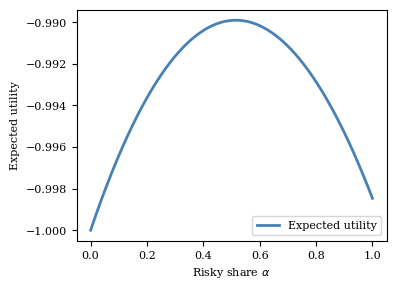

In [7]:
# Plot expected utility against grid of risky shares

import matplotlib.pyplot as plt

plt.plot(alpha, Eu, c='steelblue', lw=2.0, label='Expected utility')
plt.xlabel(r'Risky share $\alpha$')
plt.ylabel('Expected utility')
plt.legend()

#### Part (4)

We use 
[`np.argmax()`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html)
to locate the index of the risky share choice $\alpha$ which maximized expected utility:

In [8]:
# Find the index of the utility-maximizing risky share
imax = np.argmax(Eu)

# Retrieve the optimal risky share and the expected utility
share_opt = alpha[imax]
u_max = Eu[imax]

print(f'The optimal risky share is {share_opt} with expected utility {u_max}')

The optimal risky share is 0.516 with expected utility -0.989897957116286


We replicate the plot from above, but augment it with a vertical line indicating the optimal choice. This of course coincides with the maximum of the expected utility in the graph.

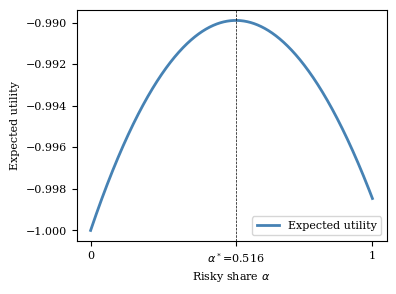

In [9]:
# Modify earlier plot to include a vertical line indicating the optimum

plt.plot(alpha, Eu, c='steelblue', lw=2.0, label='Expected utility')
plt.xlabel(r'Risky share $\alpha$')
plt.ylabel('Expected utility')
plt.legend()

# Create ticks only at the min, max and optimal risky share
plt.xticks([0.0, share_opt, 1.0], ['0', rf'$\alpha^*$={share_opt:.3f}', '1'])

# Add vertical line
plt.axvline(share_opt, color='black', ls='--', lw=0.5)

#### Part (5)

To compute the optimal risky share for each wealth level, we need to wrap the above code in a loop and store each result in an array:

In [10]:
# Wealth levels for which to compute risky share
W = np.linspace(1.0, 10.0, 100)

# Array to store optimal risky shares for each wealth level
share_opt = np.empty_like(W)

for i, Wi in enumerate(W):

    # Evaluate expected utility for all candidate risky shares
    Eu = expected_util(alpha, Wi, mu, epsilon, gamma)

    # Locate optimal choice for i-th wealth level
    imax = np.argmax(Eu)

    # Optimal share for i-th wealth level
    share_opt_i = alpha[imax]

    # Store optimal risky share for i-th wealth level
    share_opt[i] = share_opt_i

The following code plots the optimal risky share against initial wealth:

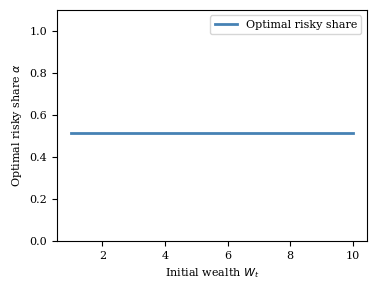

In [11]:
plt.plot(W, share_opt, c='steelblue', lw=2.0, label='Optimal risky share')
plt.xlabel('Initial wealth $W_t$')
plt.ylabel(r'Optimal risky share $\alpha$')
plt.ylim((0.0, 1.1))
plt.legend()

As you can see, the optimal risky share is a flat line, i.e., it is independent of the initial wealth level. This is a feature of CRRA preferences which arises if there is no other non-asset income in the model (such as labor earnings).

# Exercise 2: Computing the mean for increasing sample sizes

In this exercise, you are asked to investigate how the mean of a simulated sample depends on the sample size.

Consider a set of random draws with samples sizes of
5, 10, 50, 100, 500, 1000, 5000, 10000, and 100000.

1. For each sample size, draw a 
    [normally-distributed]([`normal()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.RandomState.normal.html)) 
    sample with mean $\mu = 1$
    and standard deviation $\sigma=1$. Use a seed of 678 and make 
    sure to reset the seed for each sample size.

2.  For each sample size, compute the sample mean using 
    [`np.mean()`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html).
    Print a list of sample sizes and sample means.

3.  Plot the means you computed against the sample size on the $x$-axis. You should use 
    a log-scale for the $x$-axis and a marker symbol `'o'` to make the graph
    easier to read. Add a dashed horizontal to indicate the true mean,
    and label both axes.

    *Hint:* You can set the axis scale using 
    [`xscale()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xscale.html).

    *Hint:* You can add a horizontal line with 
    [`axhline()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axhline.html).

### Solution

#### Part (1) + (2)

In [12]:
import numpy as np

# Seed used for all RNG instances
seed = 678

# Sample sizes
sizes = np.array((5, 10, 50, 100, 500, 1000, 5000, 10000, 100000))

# True mean
mu = 1.0
# Standard deviation
sigma = 1.0

# Means computed for different sample sizes
means = []

for i, n in enumerate(sizes):
    # Reset RNG with the same seed to get the same initial sequence of numbers
    rng = np.random.default_rng(seed)

    # Draw normally distributed sample
    data = rng.normal(loc=mu, scale=sigma, size=n)

    # Mean for the current draw
    mu_hat = np.mean(data)

    means.append(mu_hat)

    print(f'Mean for sample size {n:6d}: {mu_hat:.4f}')


Mean for sample size      5: 0.8462
Mean for sample size     10: 0.9152
Mean for sample size     50: 1.1534
Mean for sample size    100: 1.1333
Mean for sample size    500: 1.0732
Mean for sample size   1000: 1.0677
Mean for sample size   5000: 1.0028
Mean for sample size  10000: 1.0159
Mean for sample size 100000: 1.0057


#### Part (3)

Text(0, 0.5, 'Estimated mean')

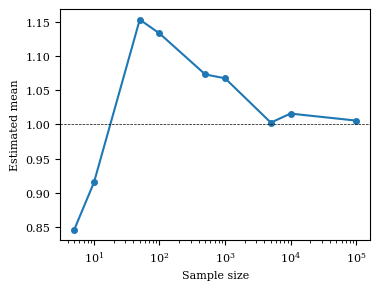

In [13]:
import matplotlib.pyplot as plt

# Plot means against sample sizes
plt.plot(sizes, means, marker='o', ms=4)

# Set log scale for x-axis
plt.xscale('log')

# Plot true mean
plt.axhline(mu, color='black', lw=0.5, ls='--')

# Add axes labels
plt.xlabel('Sample size')
plt.ylabel('Estimated mean')


The graph shows that the sample mean converges to the true mean as the sample size increases (this is called the Law of Large Numbers).

# Exercise 3: Ordinary Least Squares (OLS)

In this exercise, you are asked to draw a sample from a bivariate normal distribution (i.e., a multivariate normal distribution where the number of dimensions is 2) and estimate a linear relationship using Ordinary Least Squares (OLS).

Consider the liner model
$$
y_i = \alpha + \beta x_i + \epsilon_i
$$
where $x$ is the explanatory (or exogenous, or independent) variable and $y$ is the outcome (or dependent) variable.
The relationship is imperfect, so for each observation $i$ there is an additive error term $\epsilon_i$.

1.  Assume that $(x,y)$ are drawn from a bivariate normal distribution,
    $$
    (x, y) \stackrel{\text{iid}}{\sim} \mathcal{N}(\bm{\mu}, \bm{\Sigma})
    $$
    with
    $$
    \bm{\mu} = \begin{bmatrix} \mu_x \\ \mu_y\end{bmatrix}, \qquad 
    \bm{\Sigma} =\begin{bmatrix} \sigma_x^2 & \rho \sigma_x \sigma_y \\ \rho\sigma_x\sigma_y & \sigma_y^2\end{bmatrix}
    $$
    where $\bm{\mu}$ is the vector of means, $\bm\Sigma$ is the variance-covariance (VCV) matrix,
    $\sigma_x$ and $\sigma_y$ are the standard deviations for $x$ and $y$, respectively, and 
    $\rho$ is the correlation between $x$ and $y$.

    For this exercise, let $\mu_x = 0$, $\mu_y = 1$, $\sigma_x = 0.1$, $\sigma_y = 0.5$, and $\rho = 0.7$.

    Compute and report the VCV implied by these parameters.

2.  Use the variance-covariance matrix and the vector of means to draw $N=200$ observations of 
    $(x, y)$ from a bivariate normal distribution. Use a seed of `123`.

    Create a scatter plot with $x$ and the $x$-axis to visualize the sample.

    *Hint:* The bivariate normal is just a special case of the multivariate normal distribution,
    so you can use 
    [multivariate_normal()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html)
    for this task.

3.  Since this linear model has only one explanatory variable, the estimate of $\beta$ denoted
    by $\widehat{\beta}$ is given by the formula
    $$
    \widehat{\beta} = \frac{\widehat{\text{Cov}}(x, y)}{\widehat{\text{Var}}(x)}
    $$
    where $\widehat{\text{Cov}}(x,y)$ is the sample covariance of between $x$ and $y$,
    and $\widehat{\text{Var}}(x)$ is the sample variance of $x$.

    With $\widehat{\beta}$ in hand, the estimate for the intercept $\alpha$ is given by the formula
    $$
    \widehat{\alpha} = \overline{y} - \widehat{\beta} \overline{x}
    $$
    where $\overline{y}$ and $\overline{x}$ are the sample means of $y$ and $x$, respectively.

    Use the above formulas to compute the OLS estimate for $(\widehat{\alpha}, \widehat{\beta})$
    for the sample you have drawn.

    *Hint:* Use the functions
    [np.mean()](https://numpy.org/doc/stable/reference/generated/numpy.mean.html),
    [np.var()](https://numpy.org/doc/stable/reference/generated/numpy.var.html),
    and 
    [np.cov()](https://numpy.org/doc/stable/reference/generated/numpy.cov.html)
    to compute the sample mean, variance, and covariance.

4.  Augment the scatter plot you created earlier and add the regression line 
    using the estimates $(\widehat{\alpha}, \widehat{\beta})$.
    This regression line passes through the coordinate $(0, \widehat{\alpha})$
    and has a slope given by $\widehat{\beta}$.

    *Hint:* Use the function 
    [axline()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axline.html)
    to add a straight line to a plot.

5.  Since you know the parameters of the true model, you can compare the 
    estimate $\widehat{\beta}$ to the true value $\beta$.

    For this model, the true $\beta$ is given by the formula
    $$
    \beta = \frac{\rho \sigma_x \sigma_y}{\sigma_x^2}
    $$
    Compute this true $\beta$ and compare it to your estimate $\widehat{\beta}$.

## Solution

### Part (1)

As a first step, we define the parameters for this problem:

In [14]:
import numpy as np

# Mean (mu_x, mu_y)
mu_x = 0
mu_y = 1
mu = np.array([mu_x, mu_y])

# Standard deviations
sigma_x = 0.1
sigma_y = 0.5

# Correlation between x and y
rho = 0.7

We can now construct the variance-covariance matrix using the above formula:

In [15]:
# Compute the covariance
cov = rho * sigma_x * sigma_y

# Variance-covariance matrix
vcv = np.array([[sigma_x**2, cov], [cov, sigma_y**2]])

print(f'Variance-covariance matrix:\n{vcv}')

Variance-covariance matrix:
[[0.01  0.035]
 [0.035 0.25 ]]


### Part (2)

We draw the bivariate normal sample using 
[multivariate_normal()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html).
Note that this function returns one observation *per row*, so the first row corresponds to $(x_1, y_1)$, the second to $(x_2, y_2)$ and so on. The first column therefore stores the values of $x$ and the second the values of $y$.

In [16]:
from numpy.random import default_rng

# Initialize the random number generator with seed 123
rng = default_rng(seed=123)

# Number of observations
N = 200

# Draw N random samples from the bivariate normal distribution
data = rng.multivariate_normal(mean=mu, cov=vcv, size=N)

# Unpack the bivariate data
x, y = data.T

# Alternative way to extract x and y
# x = data[:, 0]
# y = data[:, 1]

We use
[scatter()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html)
to create the scatter plot of $y$ vs. $x$.

Text(0.5, 1.0, 'Bivariate normal data')

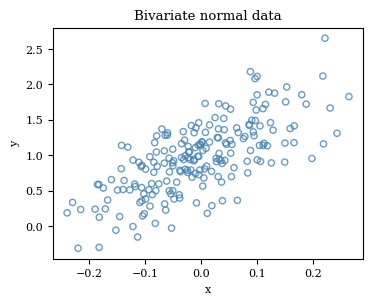

In [17]:
import matplotlib.pyplot as plt 

plt.scatter(x, y, c='none', s=20, edgecolors='steelblue', alpha=0.8)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Bivariate normal data')

### Part (3)

In a first step, we compute the sample covariance and variance of $x$:

In [18]:
# Estimate of covariance between x and y
cov_xy = np.cov(x, y)[0, 1]

# Estimate of variance of x
var_x = np.var(x)

print(f'Cov(x, y): {cov_xy:.4f}')
print(f'Var(x):    {var_x:.4f}')

Cov(x, y): 0.0358
Var(x):    0.0101


We can then use these moments to compute the estimate of $\beta$. Once we know $\widehat{\beta}$, we can compute the sample estimate of $\alpha$.

In [19]:
# OLS estimate of beta, the slope coefficient
beta_hat = cov_xy / var_x

# OLS estimate of alpha, the intercept
alpha_hat = np.mean(y) - beta_hat * np.mean(x)

print(f'Estimated alpha: {alpha_hat:.4f}')
print(f'Estimated beta:  {beta_hat:.4f}')

Estimated alpha: 0.9822
Estimated beta:  3.5531


### Part (4)

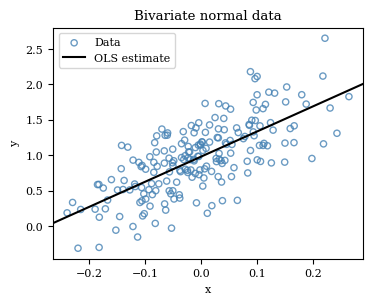

In [20]:
import matplotlib.pyplot as plt 

plt.scatter(x, y, c='none', s=20, edgecolors='steelblue', alpha=0.8, label='Data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Bivariate normal data')
plt.axline((0, alpha_hat), slope=beta_hat, color='black', lw=1.5, label='OLS estimate')
plt.legend()

### Part (5)

To compute the true $\beta$, we simply plug the parameter values into the formula:

In [21]:
# Compute true value of beta from parameters
beta = rho * sigma_x * sigma_y / sigma_x**2

print(f'True beta:      {beta:.4f}')
print(f'Estimated beta: {beta_hat:.4f}')

True beta:      3.5000
Estimated beta: 3.5531
